# Data Scientist Candidate Exercise 1

The test is designed to assess your ability to work with data, perform EDA, build predictive models and communicate your findings effectively. The test is divided into 2 parts followed up with a call of 1 hour.

Data: Click here

What does the above document contain:

* Tab1: Pricing of the test property for the last 3 years and 1 year looking ahead.
* Tab 2: Historical booking data for the test property
* Tab 3: Competitor average pricing for the 1 year ahead.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from statsmodels.tsa.seasonal import STL, seasonal_decompose

In [31]:
# Load the data from the files
pricing_data = pd.read_csv('../data/Test Data - Test Property Pricing.csv', header=1)
booking_data = pd.read_csv('../data/Test Data - Historical Booking data.csv')
competitor_data = pd.read_csv('../data/Test Data - Market Data.csv')

# Rename the columns of the data for reorganization
pricing_data.columns = ['Accommodation name', 'Property ID', 
                        'Date 2022', 'Day 2022', 'Price per night without tax 2022', 
                        'Date 2023', 'Day 2023', 'Price per night without tax 2023', 
                        'Date 2024', 'Day 2024', 'Price per night without tax 2024',
                        'Date 2025', 'Day 2025', 'Price per night without tax 2025']

# Organize the pricing data into a more usable format
data = pd.DataFrame()
years = ['2022', '2023', '2024', '2025']
for year in years:
    temp = pricing_data[['Accommodation name', 'Property ID', 'Date ' + year, 'Day ' + year, 'Price per night without tax ' + year]].copy()
    temp.columns = ['Accommodation name', 'Property ID', 'Date', 'Day', 'Price per night without tax']
    temp['Year'] = year
    data = pd.concat([data, temp], ignore_index=True)
pricing_data = data

# Fill the accommodation name and property ID for the missing values the date 31/12/2024 with the data un the previous date
pricing_data.loc[pricing_data['Date'] == '31/12/2024', 'Accommodation name'] = pricing_data.loc[pricing_data['Date'] == '30/12/2024', 'Accommodation name'].values
pricing_data.loc[pricing_data['Date'] == '31/12/2024', 'Property ID'] = pricing_data.loc[pricing_data['Date'] == '30/12/2024', 'Property ID'].values

print(f'Data 31-12-2024 {pricing_data[pricing_data["Date"] == "31/12/2024"]}')

Data 31-12-2024      Accommodation name  Property ID        Date      Day  \
1097        Test home 1     123456.0  31/12/2024  Tuesday   

      Price per night without tax  Year  
1097                        534.0  2024  


## Part 1: Data Manipulation and EDA
### Objective: Explore data, identify trends, and generate initial insights.

Task:
 
 A.) Data Cleaning:
 
 * Handle any missing values in the dataset by choosing appropriate strategies
 * Identify and remove any duplicates that may be present in the data
 * Detect and address any outliers that could skew your analysis

In [57]:
# Pricing data

# Handle missing values
print(pricing_data.isnull().sum())
missing_values_pricing = pricing_data[pricing_data[['Accommodation name', 'Property ID', 'Date', 'Day']].isnull().any(axis=1)]
print(f'--- Missing values: {missing_values_pricing}')
missing_values_pricing = pricing_data[pricing_data[['Price per night without tax']].isnull().any(axis=1)]
print(f'--- Missing values price: {missing_values_pricing}')
# Drop all the missing values
pricing_data = pricing_data.dropna()

# # Interpolate the missing values in the price column
# pricing_data = pricing_data.sort_values(by='Date')
# pricing_data['Price per night without tax'] = pricing_data['Price per night without tax'].interpolate()

# # Check for interpolated values
# print(pricing_data.loc[missing_values_pricing_index])

# Convert types to the correct format
pricing_data['Date'] = pd.to_datetime(pricing_data['Date'], format='%d/%m/%Y')
pricing_data['Day'] = pricing_data['Date'].dt.day_of_week
pricing_data['Year'] = pricing_data['Year'].astype(int)
pricing_data['Property ID'] = pricing_data['Property ID'].astype(int)
pricing_data['Accommodation name'] = pricing_data['Accommodation name'].astype(str)

# Identify and remove duplicates
duplicates = pricing_data[pricing_data.duplicated()]
print(f'--- Duplicates: {duplicates}')

Accommodation name             0
Property ID                    0
Date                           0
Day                            0
Price per night without tax    0
Year                           0
Day of the Week                0
Weekend                        0
dtype: int64
--- Missing values: Empty DataFrame
Columns: [Accommodation name, Property ID, Date, Day, Price per night without tax, Year, Day of the Week, Weekend]
Index: []
--- Missing values price: Empty DataFrame
Columns: [Accommodation name, Property ID, Date, Day, Price per night without tax, Year, Day of the Week, Weekend]
Index: []
--- Duplicates: Empty DataFrame
Columns: [Accommodation name, Property ID, Date, Day, Price per night without tax, Year, Day of the Week, Weekend]
Index: []


In [58]:
# Booking data

# # Handle missing values
# print(booking_data.isnull().sum())

# Handle missing values in the nights column
# Convwert the date columns to datetime
booking_data['Check-in date'] = pd.to_datetime(booking_data['Check-in date'], format='%d/%m/%Y')
booking_data['Check-out date'] = pd.to_datetime(booking_data['Check-out date'], format='%d/%m/%Y')
# Calculate the number of nights from the check-in and check-out dates
missing_nights_booking = booking_data['nights'].isna()
booking_data.loc[missing_nights_booking, 'nights'] = (booking_data['Check-out date'] - booking_data['Check-in date']).dt.days

# Handle missing values in the price per night column
missing_price_booking = booking_data['Price per night without tax'].isna()
# Calculate the price per night for the missing values
booking_data.loc[missing_price_booking, 'Price per night without tax'] = (booking_data.loc[missing_price_booking, 'Rent without VAT'] / booking_data.loc[missing_price_booking, 'nights']).round(2)

# Handle missing values in the website column
# Where the portal/agent is Muchosol, the website of origin is www.muchosol.es
booking_data.loc[booking_data['Portal / Agent'] == 'Muchosol', 'Website of origin'] = 'www.muchosol.es'
booking_data.loc[booking_data['Portal / Agent'] == 'booking.com', 'Website of origin'] = 'www.booking.com'
booking_data.loc[booking_data['Portal / Agent'] == 'Olalahomes.com', 'Website of origin'] = 'www.olalahomes.com'
# Fill the other missing values in the website column as they are booking directly 
booking_data['Website of origin'] = booking_data['Website of origin'].fillna('Direct')

# # Check for missing values
# print(f'--- Missing values: {booking_data.isnull().sum()}')

# Convert types to the correct format
print(booking_data.dtypes)
booking_data['Booking Date'] = pd.to_datetime(booking_data['Booking Date'], format='%d/%m/%Y')
booking_data['Accommodation name'] = booking_data['Accommodation name'].astype(str)
booking_data['Building'] = booking_data['Building'].astype(str)
booking_data['City'] = booking_data['City'].astype(str)
booking_data['Portal / Agent'] = booking_data['Portal / Agent'].astype(str)
booking_data['Website of origin'] = booking_data['Website of origin'].astype(str)

# Identify and remove duplicates
duplicates = booking_data[booking_data.duplicated()]
print(f'--- Duplicates: {duplicates}')
# There are no relevant duplicates in the booking data so we can continue

# Anotation: The Rent without VAT and the Rent with VAT are the same


Booking number                         object
Booking Date                   datetime64[ns]
Status                                 object
Check-in date                  datetime64[ns]
Check-out date                 datetime64[ns]
nights                                float64
Price per night without tax           float64
Rent with VAT on top                  float64
Rent without VAT                      float64
Extras with VAT on top                float64
Extras without VAT                    float64
Booking total with tax                float64
Booking total without tax             float64
Total tax                             float64
Paid                                  float64
Adults                                  int64
Children                                int64
Babies                                  int64
Accommodation name                     object
Property ID                             int64
Building                               object
City                              

In [59]:
# Competitor data

# Handle missing values
print(competitor_data.isnull().sum())

# Convert types to the correct format
print(competitor_data.dtypes)
competitor_data['Date'] = pd.to_datetime(competitor_data['Date'], format='%d/%m/%Y')
competitor_data['Day'] = competitor_data['Date'].dt.day_of_week

# Identify and remove duplicates
duplicates = competitor_data[competitor_data.duplicated()]
print(f'--- Duplicates: {duplicates}')
# There are no duplicates in the competitor data so we can continue


Date              0
Day               0
Competitor Avg    0
dtype: int64
Date              datetime64[ns]
Day                        int32
Competitor Avg             int64
dtype: object
--- Duplicates: Empty DataFrame
Columns: [Date, Day, Competitor Avg]
Index: []


B.) Feature Engineering & EDA:
 * Create new features that might be relevant for understanding pricing trends, such
 as:
    * **Booking window or Booking lead times:** Calculate the number of days
    between booking date and check in date. This feature will help you to
    understand how early or late bookings are made, which can influence pricing.
    For example, last-minute bookings might be priced higher or lower depending
    on the demand.
    * **Seasonality:** Find out the seasonality for the year by categorising them into
    High, medium and low seasons. This will help you understand the low,
    medium and high demand periods. Higher the demand, higher the prices and
    vice versa.
    * **Day of the week:** Review the days on which the booking falls to understand
    the demand by the day. This helps to understand what days of the week are
    people booking. For example the demand for week ends might be higher than
    the weekdays even in high season and hence the price per night cannot be
    the same for Monday and Friday.
    * **Occupancy Rate:** Calculate the occupancy rate for each month to
    understand how full the property was over time. As it helps to benchmark it
    against the past performance and market forecast. Example if we are pacing
    behind in occupancy we could offer a discount on the price to get some quick
    bookings to build the base

In [60]:
# Create new features

# Booking window or Booking lead times: The number of days between the booking date and the check-in date
booking_data['Booking window'] = (booking_data['Check-in date'] - booking_data['Booking Date']).dt.days
print(booking_data['Booking window'].head(10))

0    112
1      0
2      1
3      0
4     16
5      1
6     53
7     21
8      0
9      0
Name: Booking window, dtype: int64


Check-in Month
1      93.450
2     117.150
3     146.380
4     215.420
5     250.760
6     202.905
7     229.435
8     223.150
9     159.190
10    211.760
11    123.750
12    109.745
Name: Price per night without tax, dtype: float64
Check-in Month
1        Low
2        Low
3     Medium
4       High
5       High
6     Medium
7       High
8       High
9     Medium
10    Medium
11       Low
12       Low
Name: Price per night without tax, dtype: object


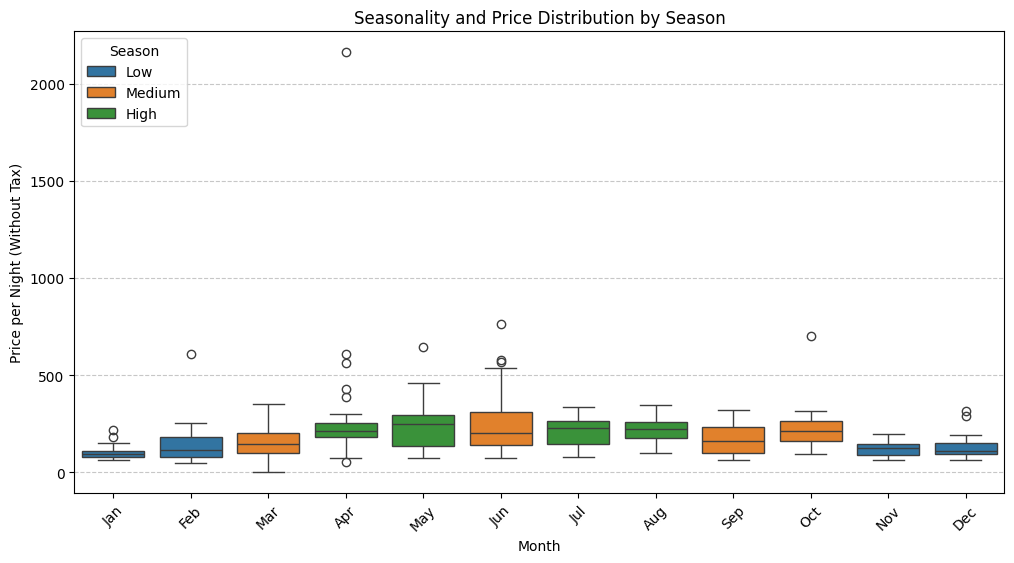

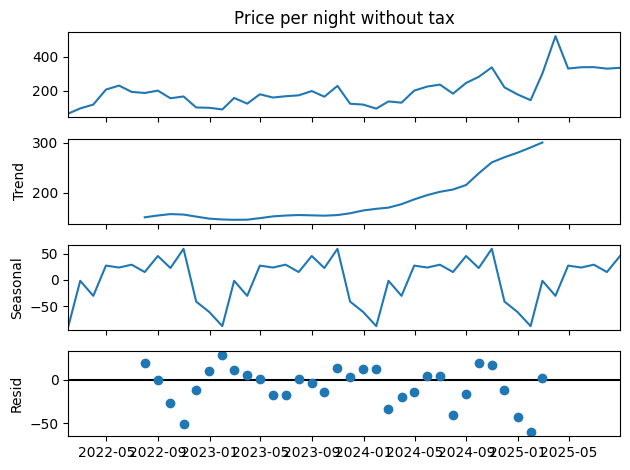

In [61]:
# Seasonality: The month of the year

# Find out the seasonality of the data categorising them into high, medium and low
booking_data['Check-in Month'] = booking_data['Check-in date'].dt.month
monthly_median = booking_data.groupby('Check-in Month')['Price per night without tax'].median()
print(monthly_median)
# Calculate the thresholds
low_season_threshold = monthly_median.quantile(0.33)  # 1rst 
high_season_threshold = monthly_median.quantile(0.66)  # Second
# Asing the season category
season_category = monthly_median.apply(lambda x: 'High' if x >= high_season_threshold 
                                       else ('Low' if x <= low_season_threshold 
                                             else 'Medium'))

print(season_category)
# Create a new column with the season category
booking_data['Season'] = booking_data['Check-in Month'].map(season_category)

# Visualize the seasonality and price distribution by season
plt.figure(figsize=(12, 6))
sns.boxplot(x=booking_data['Check-in Month'], y=booking_data['Price per night without tax'], hue=booking_data['Season'])

plt.xlabel('Month')
plt.ylabel('Price per Night (Without Tax)')
plt.title('Seasonality and Price Distribution by Season')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Season", loc="upper left")
plt.show()


# Seasonality analysis with STL in price data
price_data = pricing_data[['Date', 'Price per night without tax']].copy()
price_data = price_data.sort_values(by='Date')
price_data = price_data.set_index('Date')
price_data = price_data['Price per night without tax']
price_data = price_data.resample('ME').mean()
result_stl = seasonal_decompose(price_data, model='additive', period=12)
result_stl.plot()
plt.show()

# # Seasonality analysis with STL in booking data
# booking_price_data = booking_data[['Check-in date', 'Price per night without tax']].copy()
# booking_price_data = booking_price_data.sort_values(by='Check-in date')
# booking_price_data = booking_price_data.set_index('Check-in date')
# booking_price_data = booking_price_data['Price per night without tax']
# booking_price_data = booking_price_data.resample('ME').mean()
# booking_price_data = booking_price_data.ffill()
# result_stl = seasonal_decompose(booking_price_data, model='additive', period=12)
# result_stl.plot()
# plt.show()


Check-in Day
Friday       59
Thursday     42
Wednesday    38
Sunday       37
Monday       36
Tuesday      33
Saturday     22
Name: count, dtype: int64


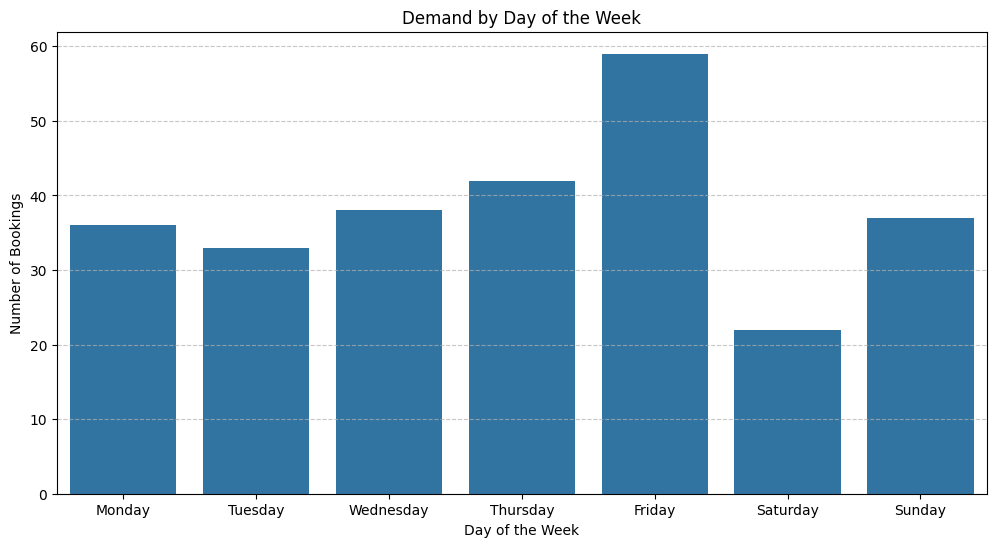

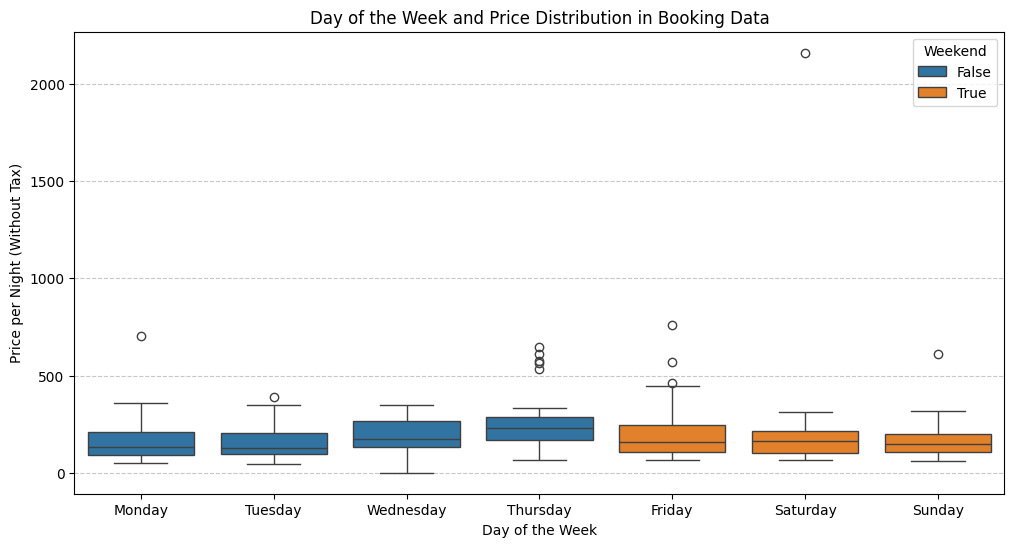

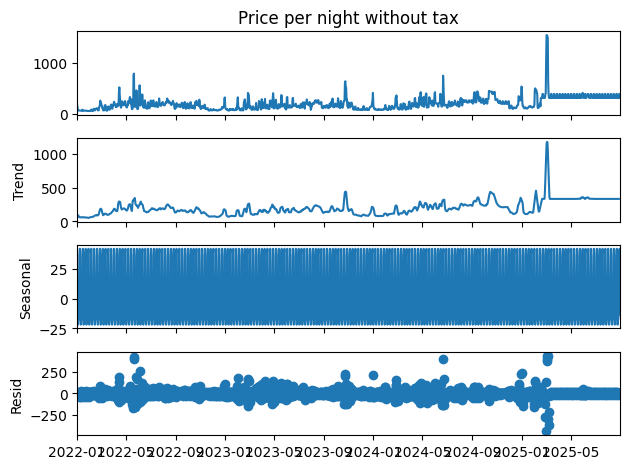

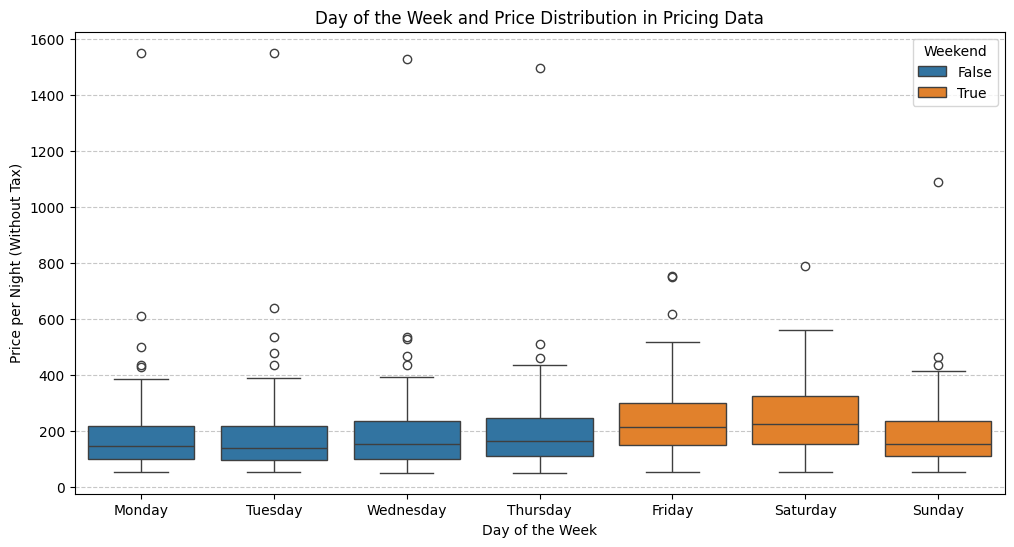

/tmp/ipykernel_31/3093022245.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  season_day_price = booking_data.groupby(['Season', 'Check-in Day'])['Price per night without tax'].median().unstack()


Check-in Day   Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
Season                                                                       
High          132.000  176.925    235.670   278.500  243.10    211.06   169.5
Low            97.810   87.000    117.020   142.775  112.97     87.64    95.4
Medium        160.205  153.085    167.065   234.765  189.50    145.82   140.0


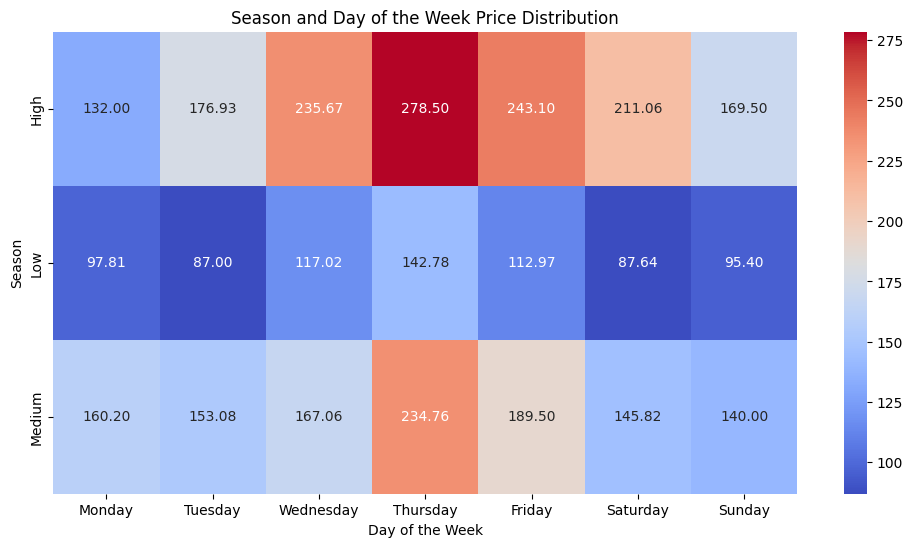

/tmp/ipykernel_31/3093022245.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_demand = booking_data.groupby(['Season', 'Check-in Day']).size().unstack()


Check-in Day  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
Season                                                                      
High              13       14         13        18      17        10      17
Low                9        7          9        10      22         7      13
Medium            14       12         16        14      20         5       7


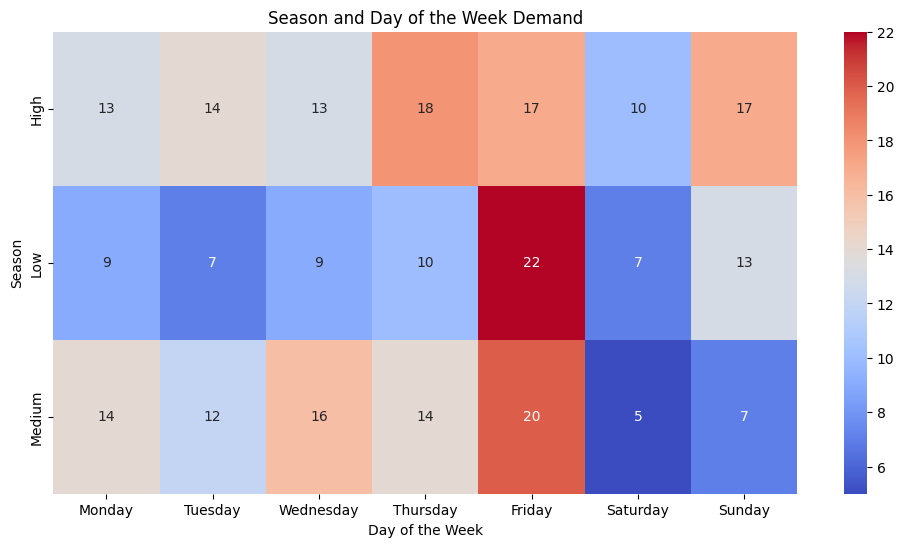

In [62]:
# Day of the week:  
# Review the days on which the booking falls to understand the demand by the day. This helps to understand what days of the week are
# people booking. For example the demand for week ends might be higher than the weekdays even in high season and hence the price per night cannot be
# the same for Monday and Friday.

booking_data['Check-in Day'] = booking_data['Check-in date'].dt.day_name()
demand_by_day = booking_data['Check-in Day'].value_counts()
print(demand_by_day)

# Sort the days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
demand_by_day = demand_by_day.reindex(days)

# Visualize the demand by day of the week
plt.figure(figsize=(12, 6))
sns.barplot(x=demand_by_day.index, y=demand_by_day.values)

plt.xlabel('Day of the Week')
plt.ylabel('Number of Bookings')
plt.title('Demand by Day of the Week')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Sort the days of the week
booking_data['Check-in Day'] = pd.Categorical(booking_data['Check-in Day'], categories=days, ordered=True)
# Define weekends and weekdays
weekends = ['Friday', 'Saturday', 'Sunday']
booking_data['Weekend'] = booking_data['Check-in Day'].isin(weekends)

# Visualize the day of the week and price distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x=booking_data['Check-in Day'], y=booking_data['Price per night without tax'], hue=booking_data['Weekend'])

plt.xlabel('Day of the Week')
plt.ylabel('Price per Night (Without Tax)')
plt.title('Day of the Week and Price Distribution in Booking Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Day of the week analysis with STL in price data
pricing_data['Date'] = pd.to_datetime(pricing_data['Date'])
price_data = pricing_data[['Date', 'Price per night without tax']].copy()
price_data = price_data.sort_values(by='Date')
price_data = price_data.set_index('Date')
price_data = price_data['Price per night without tax']
price_data = price_data.resample('D').mean()

# Check again for any potential missing values after resampling
if price_data.isna().any():
    print("Missing values after resampling:\n", price_data[price_data.isna()])

result_stl = seasonal_decompose(price_data, model='additive', period=7)
result_stl.plot()
plt.show()

# Sort the days of the week
pricing_data['Day of the Week'] = pricing_data['Date'].dt.day_name()
pricing_data['Day of the Week'] = pd.Categorical(pricing_data['Day of the Week'], categories=days, ordered=True)
# Define weekends and weekdays
pricing_data['Weekend'] = pricing_data['Day of the Week'].isin(weekends)
# Visualize the weekends and weekdays price distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x=pricing_data['Day of the Week'], y=pricing_data['Price per night without tax'], hue=pricing_data['Weekend'])

plt.xlabel('Day of the Week')
plt.ylabel('Price per Night (Without Tax)')
plt.title('Day of the Week and Price Distribution in Pricing Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Group by season and day of the week
season_day_price = booking_data.groupby(['Season', 'Check-in Day'])['Price per night without tax'].median().unstack()
print(season_day_price)

# Visualize the season and day of the week price distribution
plt.figure(figsize=(12, 6))
sns.heatmap(season_day_price, cmap='coolwarm', annot=True, fmt=".2f")

plt.xlabel('Day of the Week')
plt.ylabel('Season')
plt.title('Season and Day of the Week Price Distribution')
plt.show()

# Group by season and day of the week
seasonal_demand = booking_data.groupby(['Season', 'Check-in Day']).size().unstack()
print(seasonal_demand)

# Visualize the season and day of the week demand
plt.figure(figsize=(12, 6))
sns.heatmap(seasonal_demand, cmap='coolwarm', annot=True, fmt="d")

plt.xlabel('Day of the Week')
plt.ylabel('Season')
plt.title('Season and Day of the Week Demand')
plt.show()


Check-in Month
1     55.000000
2     81.666667
3     83.333333
4     80.000000
5     75.833333
6     82.500000
7     91.666667
8     95.833333
9     71.666667
10    53.333333
11    59.166667
12    63.333333
Name: nights, dtype: float64


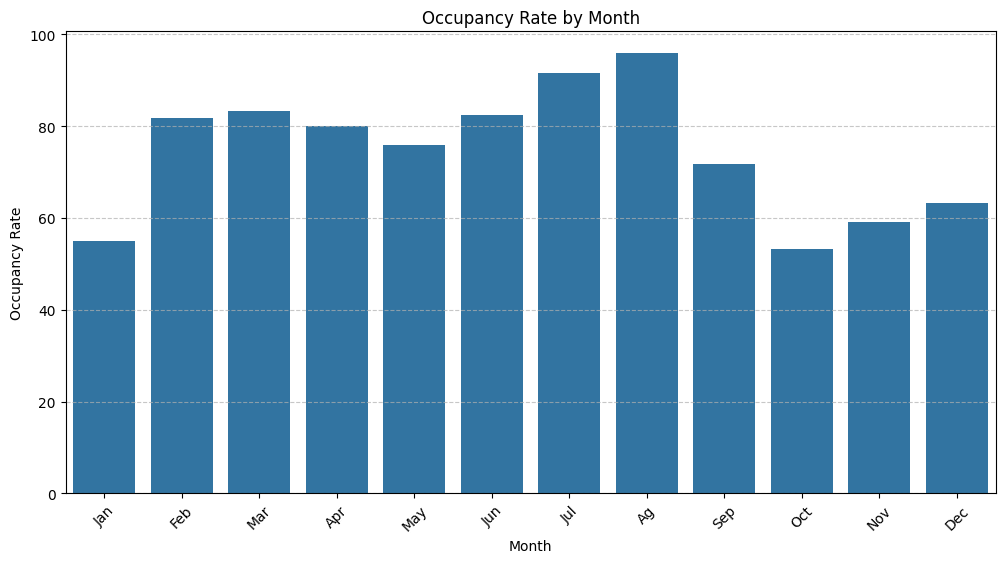

In [ ]:
# Occupancy Rate: Calculate the occupancy rate for each month to understand how full the property was over time. As it helps to benchmark it
# against the past performance and market forecast. Example if we are pacing behind in occupancy we could offer a discount on the price to get some quick
# bookings to build the base

# Calculate the occupancy rate for each month
# Assuming that the property has 4 rooms and each room is booked for 30 days in a month
monthly_occupancy = booking_data.groupby('Check-in Month')['nights'].sum() / (30 * 4) * 100
print(monthly_occupancy)

# Visualize the occupancy rate by month
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_occupancy.index, y=monthly_occupancy.values)

plt.xlabel('Month')
plt.ylabel('Occupancy Rate')
plt.title('Occupancy Rate by Month')

plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Ag', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Market Demand: Understand the market demand by looking at the number of bookings made on each day. This helps to understand the demand
# and supply in the market and helps to price the property accordingly. Example if the demand is high and supply is low then we can increase the price
# and vice versa.



Exploratory Data Analysis (EDA):

* Calculate the Mean, Median, standard deviation, Min and max values of below mentioned numerical features:

    * **Occupancy rate**
    * **Lead time**
    * **Length of stay**

* Visualisation:

    * The features they created in the first part of the exercise to spot trends.

* Correlation Analysis:

    *   Perform a correlation analysis between the features and the price per night to understand which features are strongly associated or have the biggest impact on the price per night.

--- Occupancy Rate ---
count    12.000000
mean     74.444444
std      14.049576
min      53.333333
25%      62.291667
50%      77.916667
75%      82.708333
max      95.833333
Name: nights, dtype: float64

--- Booking Window ---
count    267.000000
mean      11.689139
std       16.081933
min      -58.000000
25%        1.000000
50%        5.000000
75%       21.000000
max      112.000000
Name: Booking window, dtype: float64

--- Length of Stay ---
count    267.000000
mean       4.014981
std        3.011220
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       28.000000
Name: nights, dtype: float64



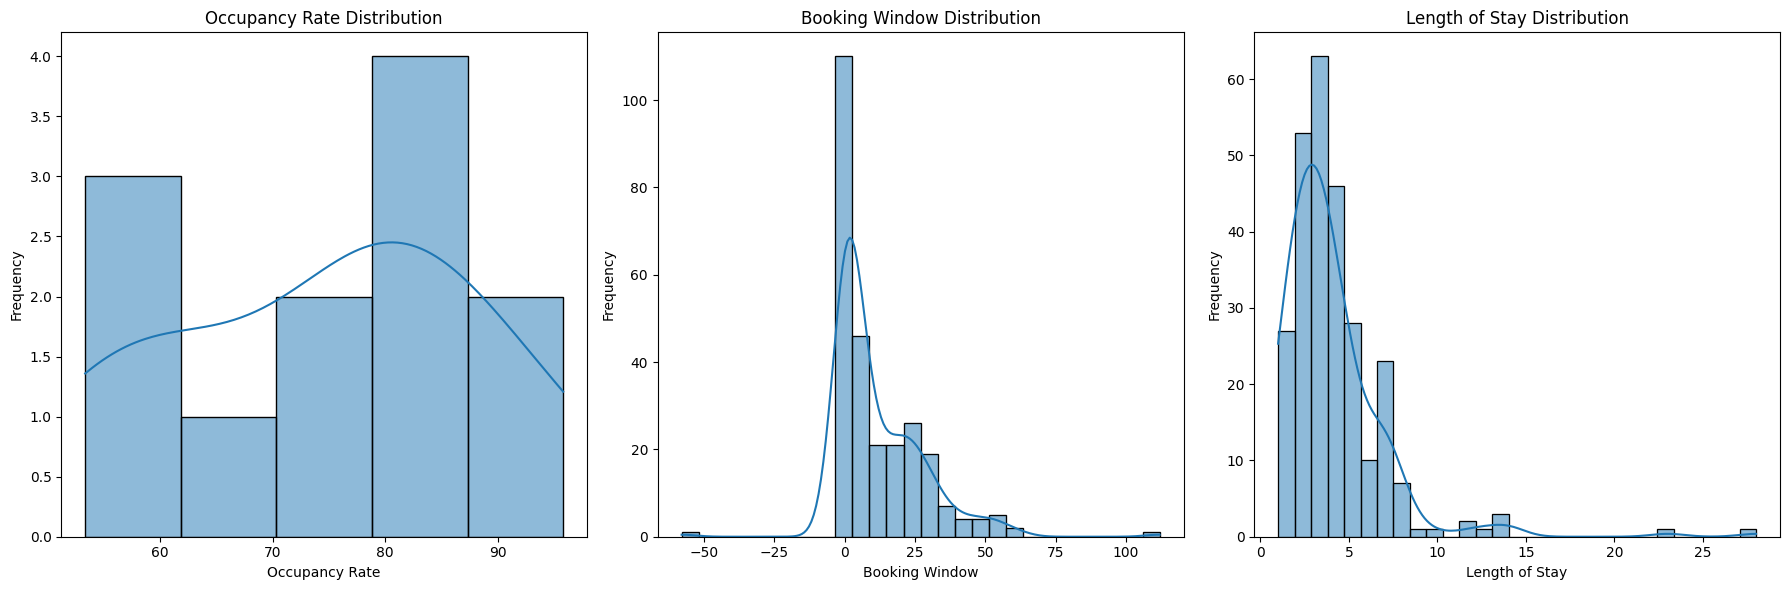

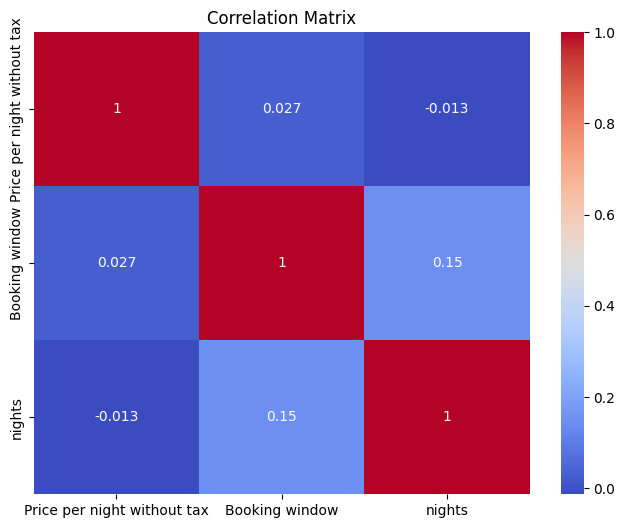

In [ ]:
# Explorative Data Analysis

# Calculate the mean, median, standard deviation, min and max values of occupancy rate, lead time, and length of stay
stats = {}

# Occupancy rate
stats['Occupancy Rate'] = monthly_occupancy.describe()

# Booking window
stats['Booking Window'] = booking_data['Booking window'].describe()

# Length of stay
stats['Length of Stay'] = booking_data['nights'].describe()

# Print the statistics
for key, value in stats.items():
    print(f'--- {key} ---\n{value}\n')

# Visualize the distribution of the occupancy rate, booking window, and length of stay
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(monthly_occupancy, kde=True)
plt.xlabel('Occupancy Rate')
plt.ylabel('Frequency')
plt.title('Occupancy Rate Distribution')

plt.subplot(1, 3, 2)
sns.histplot(booking_data['Booking window'], kde=True)
plt.xlabel('Booking Window')
plt.ylabel('Frequency')
plt.title('Booking Window Distribution')

plt.subplot(1, 3, 3)
sns.histplot(booking_data['nights'], kde=True)
plt.xlabel('Length of Stay')
plt.ylabel('Frequency')
plt.title('Length of Stay Distribution')

plt.tight_layout()
plt.show()

Most significant correlations with the price per night:
Price per night without tax      1.000000
Booking number_TEST252           0.722455
Rent with VAT on top             0.409266
Rent without VAT                 0.409266
Booking total without tax        0.403993
Booking total with tax           0.403297
Paid                             0.386362
Portal / Agent_Direct Booking    0.245027
Website of origin_nan            0.211927
Booking number_TEST16            0.207231
Total tax                        0.201091
Booking number_TEST76            0.185538
Booking number_TEST184           0.164273
Booking number_TEST137           0.152062
Booking number_TEST191           0.151694
Check-in Day_Thursday            0.150973
Booking number_TEST111           0.139506
Booking number_TEST183           0.137020
Booking number_TEST122           0.134645
Booking Date                     0.133648
Name: Price per night without tax, dtype: float64


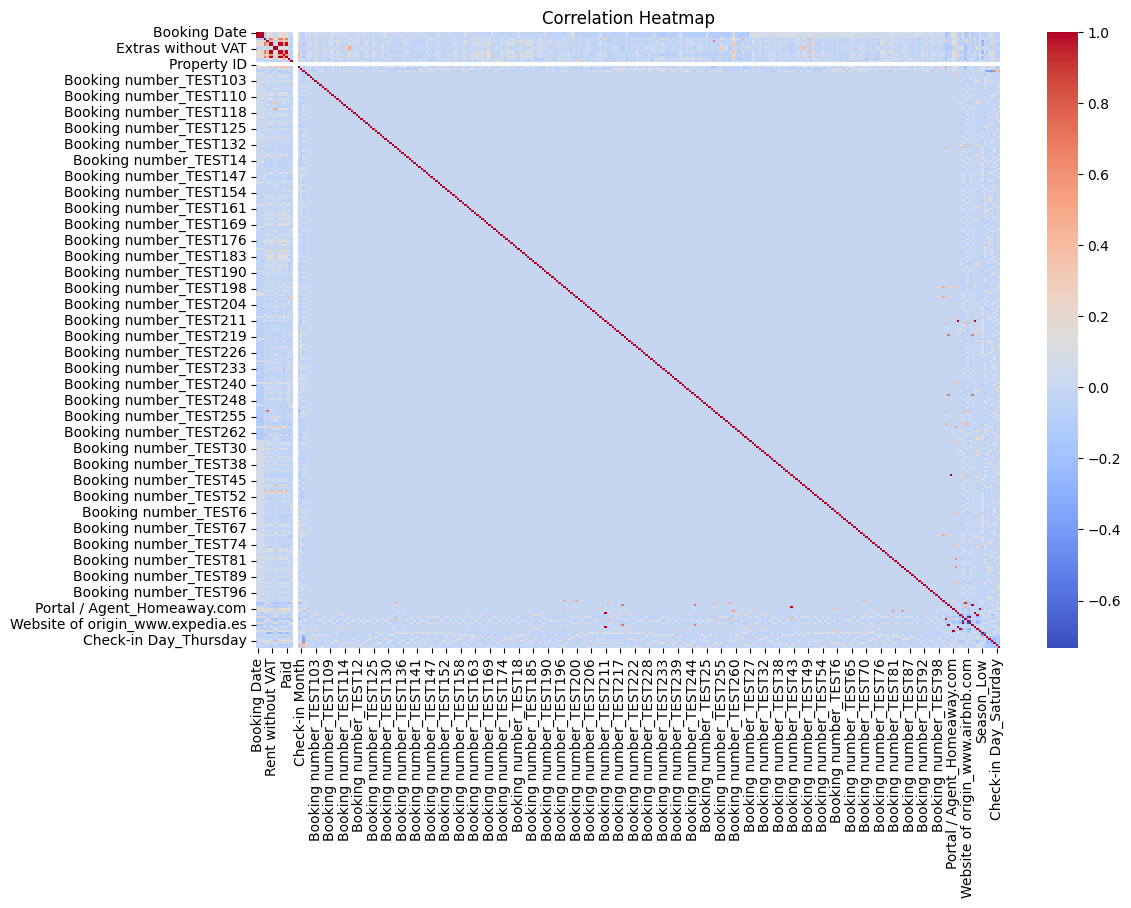

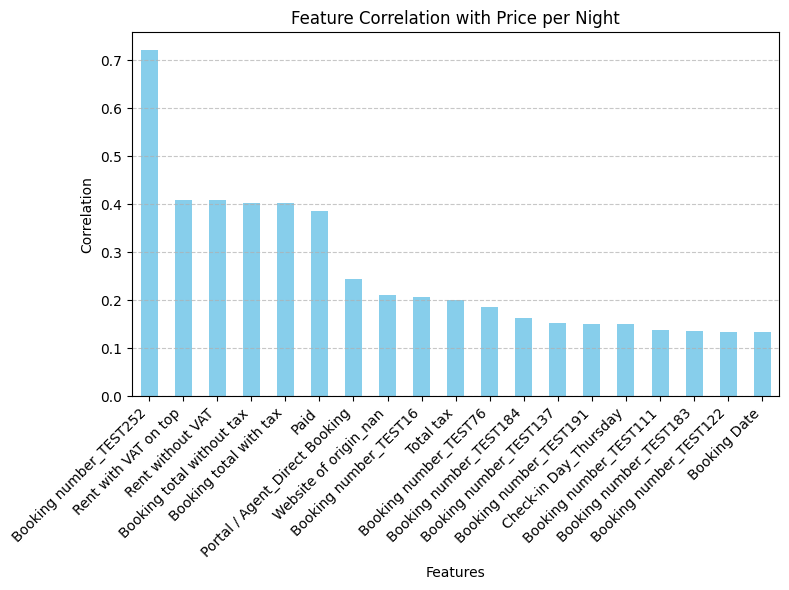

: 

In [71]:
# Correlation Analysis

# Select the relevant columns (make sure to include 'Price per night without tax')
relevant_features = booking_data.copy()

# Convert categorical data to dummies (if there are categorical columns)
relevant_features = pd.get_dummies(relevant_features, drop_first=True)

# Clean the data
noisy_features = ['Booking number', 'Rent without VAT']
relevant_features = relevant_features.drop(noisy_features, axis=1)


# Calculate the correlation matrix
correlation_matrix = relevant_features.corr()

# Filter the correlations with respect to 'Price per night without tax'
price_corr = correlation_matrix['Price per night without tax'].sort_values(ascending=False)



# Show the most significant correlations
print("Most significant correlations with the price per night:")
print(price_corr)

# Visualize the correlations as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, cbar=True)

plt.title('Correlation Heatmap')
plt.show()

# If you prefer to see only the correlations with the price
plt.figure(figsize=(8, 6))
price_corr.drop('Price per night without tax').plot(kind='bar', color='skyblue')

plt.title('Feature Correlation with Price per Night')
plt.ylabel('Correlation')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

